<a href="https://colab.research.google.com/github/yiruchen4/Chen2025/blob/main/Code/ChenFigure4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Imported libraries and functions
!pip install pingouin > /dev/null 2>&1
from scipy.stats import friedmanchisquare, wilcoxon
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import warnings

warnings.filterwarnings("ignore")


🕒 Acrophase difference (Feeding - Seeking):
Mean = -1.747 h | SD = 0.887 | SE = 0.280
Wilcoxon Acrophase p-value: 0.00195


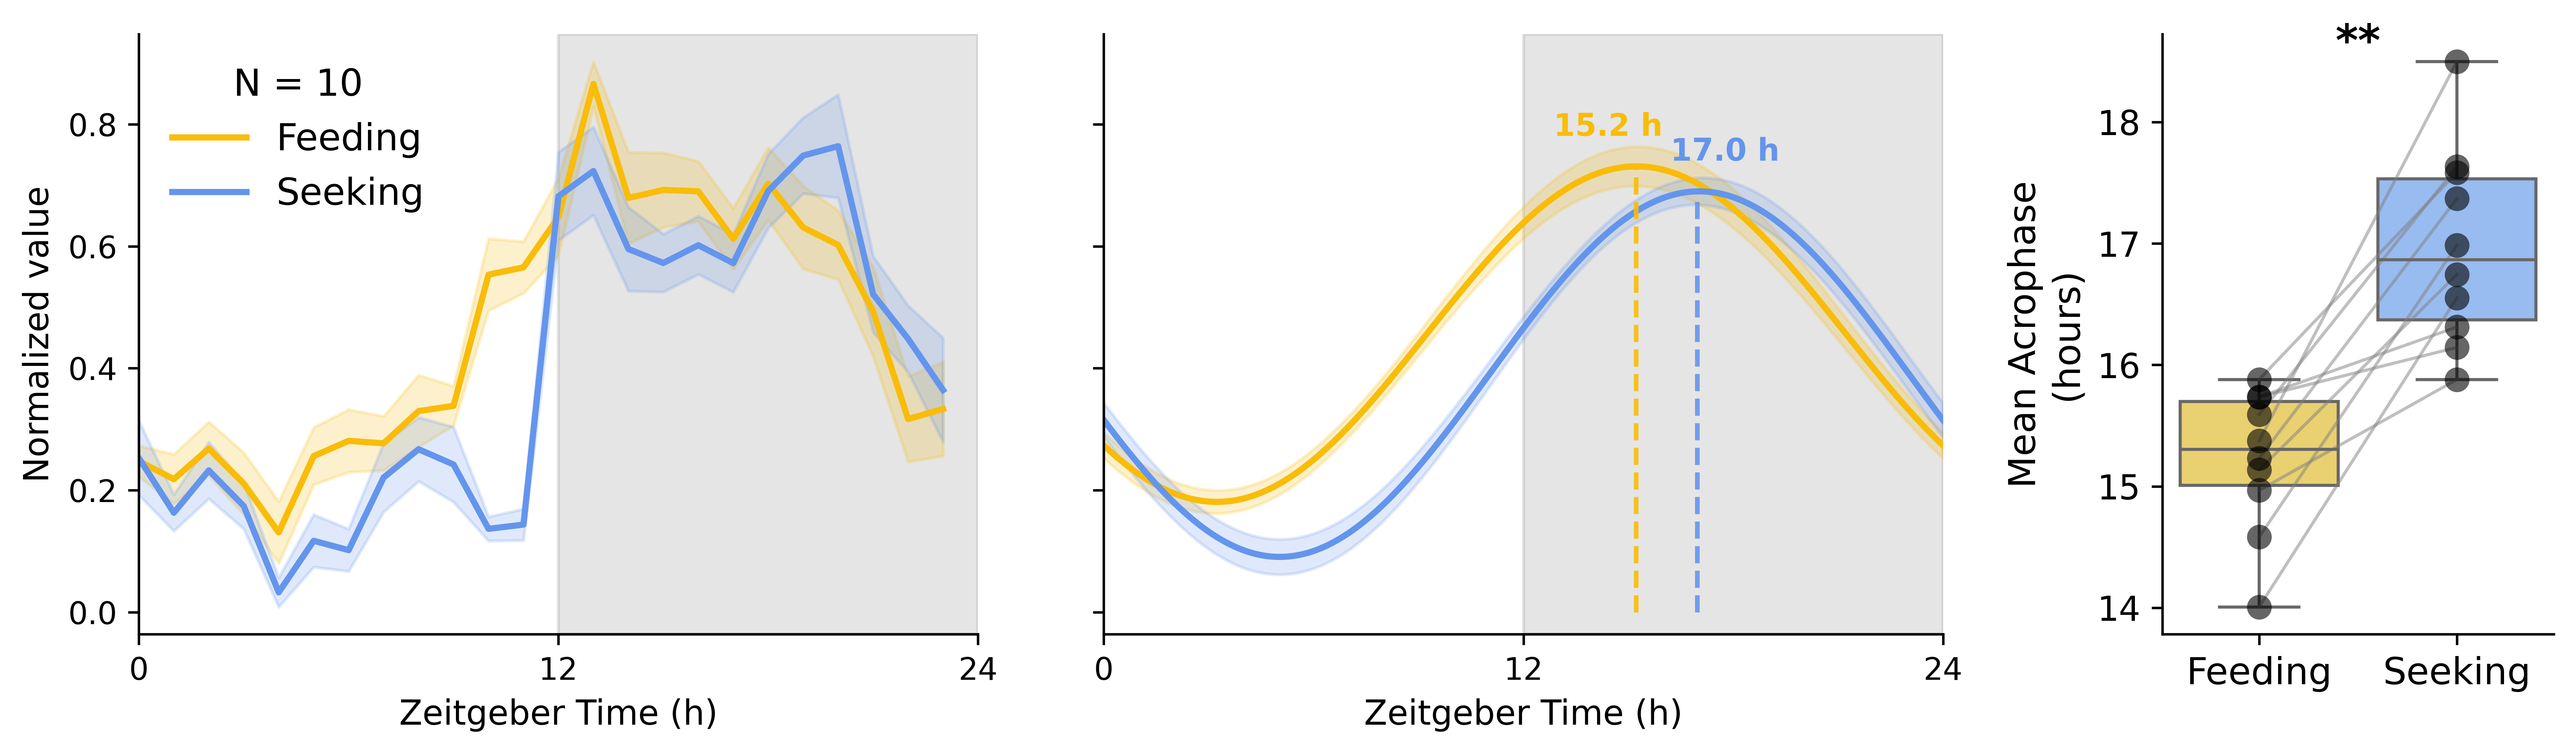

In [2]:
# @title Figure 4A-B
df = pd.read_csv(r'https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_Figure4_ab.csv')
# === Convert wide format to long ===
df_long = df.melt(id_vars=['Mouse', 'Measurement'],
                  var_name='Hour', value_name='Value')
scaler = MinMaxScaler()
df_long['Scaled_Value'] = df_long.groupby(['Measurement','Mouse'])['Value'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# Convert Hour to int
df_long['Hour'] = df_long['Hour'].astype(int)

# === Pivot so each measurement type becomes a column ===
df_pivot = df_long.pivot_table(index=['Mouse', 'Hour'],
                                columns='Measurement', values='Scaled_Value').reset_index()

# === Define cosinor model ===
def cosinor(t, mesor, amplitude, acrophase):
    return mesor + amplitude * np.cos(2 * np.pi * (t - acrophase) / 24)

# === Compute and print paired summary stats for acrophase and amplitude ===
def paired_stats(df, value_col):
    wide = df.pivot(index='Mouse', columns='Measurement', values=value_col)
    if 'Feeding' in wide.columns and 'Seeking' in wide.columns:
        diff = wide['Feeding'] - wide['Seeking']
        mean_diff = diff.mean()
        sd_diff = diff.std(ddof=1)
        se_diff = sd_diff / np.sqrt(len(diff))
        return mean_diff, sd_diff, se_diff
    else:
        return np.nan, np.nan, np.nan

def p_to_star(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'  # optional: or return an empty string ""

# === Run cosinor analysis per Mouse and Measurement ===
fit_results = []

for measurement in ['Feeding', 'Seeking']:
    for mouse_id, group in df_pivot.groupby('Mouse'):
        if measurement not in group.columns:
            continue

        hourly = group.set_index('Hour')[measurement].reindex(range(24), fill_value=np.nan)
        hourly = hourly.interpolate(method='spline', order=2, limit_direction='both')

        t = hourly.index.to_numpy()
        y = hourly.values
        guess = [np.mean(y), (np.max(y) - np.min(y)) / 2, 0]

        try:
            params, _ = curve_fit(cosinor, t, y, p0=guess)
            mesor, amplitude, acrophase = params

            if amplitude < 0:
                amplitude = -amplitude
                acrophase = (acrophase + 12) % 24

            t_fit = np.linspace(0, 24, 1000)
            y_fit = cosinor(t_fit, mesor, amplitude, acrophase)
            fit_peak_hour = t_fit[np.argmax(y_fit)]

            y_pred = cosinor(t, mesor, amplitude, acrophase)
            r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)

        except RuntimeError:
            mesor, amplitude, acrophase, fit_peak_hour, r2 = [np.nan] * 5

        fit_results.append({
            'Mouse': mouse_id,
            'Measurement': measurement,
            'MESOR': mesor,
            'Amplitude': amplitude,
            'Acrophase_Hour': fit_peak_hour,
            'R_squared': r2
        })

fit_df = pd.DataFrame(fit_results)

# Convert hours to radians
fit_df['Acrophase_rad'] = 2 * np.pi * fit_df['Acrophase_Hour'] / 24

# Define circular mean function (safe for radians)
def circ_mean(theta):
    sin_sum = np.sum(np.sin(theta))
    cos_sum = np.sum(np.cos(theta))
    return np.arctan2(sin_sum, cos_sum) % (2 * np.pi)

# Prepare list to collect results
circ_summary = []

# Loop through each Mouse × Measurement pair
for (mouse, measurement), sub in fit_df.groupby(['Mouse', 'Measurement']):
    theta = sub['Acrophase_rad'].dropna().values
    if len(theta) == 0:
        continue

    mu = circ_mean(theta)
    circ_summary.append({
        'Mouse': mouse,
        'Measurement': measurement,
        'Acrophase_rad_mean': mu,
        'Acrophase_deg_mean': np.degrees(mu) % 360,
        'Acrophase_hour_mean': (24 * mu / (2 * np.pi)) % 24
    })

# Create the summary DataFrame
acrophase_df = pd.DataFrame(circ_summary)

t_fit = np.linspace(0, 24, 1000)
measurements = ['Feeding', 'Seeking']
color_map = {'Feeding': '#f9bc08', 'Seeking': 'cornflowerblue'}
legend_order = ['Feeding', 'Seeking']

all_fits = []

for measure in measurements:
    for mouse_id in df_pivot['Mouse'].unique():
        result = fit_df[(fit_df['Mouse'] == mouse_id) &
                          (fit_df['Measurement'] == measure)]

        if result.empty or result.isna().any().any():
            continue

        mesor = result['MESOR'].values[0]
        amp = result['Amplitude'].values[0]
        acro = result['Acrophase_Hour'].values[0]

        y_fit = cosinor(t_fit, mesor, amp, acro)

        temp_df = pd.DataFrame({
            'Time': t_fit,
            'Fitted': y_fit,
            'Mouse': mouse_id,
            'Measurement': measure
        })
        all_fits.append(temp_df)

fit_df_all = pd.concat(all_fits, ignore_index=True) if all_fits else pd.DataFrame()

# Set up main layout: 1 row, 3 columns (left: timecourse, center: fit, right: boxplots)

fig = plt.figure(figsize=(14, 3.5), dpi=600)
outer = GridSpec(1, 3, width_ratios=[1.5, 1.5, 0.7], wspace=0.25)

ax1 = fig.add_subplot(outer[0])
ax2 = fig.add_subplot(outer[1], sharey=ax1)  # sharey from ax1
plt.setp(ax2.get_yticklabels(), visible=False)

# Right column: stacked acrophase + amplitude
ax_box1 = fig.add_subplot(outer[2])  # Only Acrophase plot now

# --- LEFT: Behavior over time ---
df_long['Hour'] = pd.to_numeric(df_long['Hour'])

sns.lineplot(
    data=df_long,
    x='Hour',
    y='Scaled_Value',
    hue='Measurement',
    hue_order=legend_order,
    errorbar='se',
    palette=color_map,
    linewidth=2,
    ax=ax1
)

ax1.axvspan(12, 24, color='gray', alpha=0.2, zorder=0)
ax1.set_xticks([0, 12, 24])
ax1.set_xlim(0, 24)
ax1.set_xlabel('Zeitgeber Time (h)', fontsize=11)
ax1.set_ylabel('Normalized value', fontsize=11)
ax1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=5))
sns.despine(ax=ax1)
ax1.legend(title=f"N = {df_long['Mouse'].nunique()}",
            title_fontsize=12, loc='upper left', frameon=False, fontsize=12)

# --- CENTER: Cosinor fit ---
if not fit_df_all.empty:
    sns.lineplot(
        data=fit_df_all,
        x='Time',
        y='Fitted',
        hue='Measurement',
        palette=color_map,
        errorbar='se',
        hue_order=legend_order,
        linewidth=2,
        ax=ax2
    )
    ax2.axvspan(12, 24, color='gray', alpha=0.2, zorder=0)
    ax2.set_xticks([0, 12, 24])
    ax2.set_xlim(0, 24)
    ax2.set_xlabel('Zeitgeber Time (h)', fontsize=11)
    ax2.set_ylabel('Normalized value', fontsize=11)
    ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=5))
    sns.despine(ax=ax2)
    ax2.legend([], [], frameon=False)

# --- RIGHT TOP: Acrophase boxplot ---
# Pivot data to wide format for Wilcoxon
acrophase_wide = acrophase_df.pivot(index='Mouse', columns='Measurement', values='Acrophase_hour_mean')
stat_acro, pval = wilcoxon(acrophase_wide['Feeding'], acrophase_wide['Seeking'])

sns.boxplot(data=acrophase_df, x='Measurement', y='Acrophase_hour_mean',
            palette=['#fddc5c', '#8ab8fe'], ax=ax_box1)
sns.stripplot(data=acrophase_df, x='Measurement', y='Acrophase_hour_mean',
              color='k', alpha=0.6, jitter=False, size=8, ax=ax_box1)

for mouse_id, sub in acrophase_df.groupby('Mouse'):
    if sub['Measurement'].nunique() >= 2:
        sub_sorted = sub.sort_values('Measurement')
        x_vals = [measurements.index(m) for m in sub_sorted['Measurement']]
        y_vals = sub_sorted['Acrophase_hour_mean'].values
        ax_box1.plot(x_vals, y_vals, color='gray', alpha=0.5, linewidth=1)

label_star = p_to_star(pval)
ax_box1.text(0.5, 1.02, label_star,
          transform=ax_box1.transAxes, ha='center', va='top',
          fontsize=14, fontweight='bold',)

ax_box1.set_ylabel("Mean Acrophase\n(hours)", fontsize=12)
ax_box1.set_xlabel("")
ax_box1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=5))
ax_box1.tick_params(axis='y', labelsize=11)
ax_box1.tick_params(axis='x', labelsize=12)
sns.despine(ax=ax_box1)

box = ax2.get_position()
ax2.set_position([box.x0 - 0.015, box.y0, box.width, box.height])

# === Add vertical dashed lines and acrophase labels in ax2 ===
ymin, ymax = ax2.get_ylim()  # store current y-limits

for measure in measurements:
    # Mean acrophase across mice
    acro_mean = fit_df[fit_df['Measurement'] == measure]['Acrophase_Hour'].mean()

    # Get group mean fitted curve for this measurement
    subset = fit_df_all[fit_df_all['Measurement'] == measure]
    grouped_mean = subset.groupby('Time')['Fitted'].mean()
    y_at_acro = np.interp(acro_mean, grouped_mean.index.values, grouped_mean.values)
    y_at_acro = min(y_at_acro, ymax)

    # Plot vertical dashed line
    ax2.vlines(x=acro_mean, ymin=0, ymax=y_at_acro,
                color=color_map[measure], linestyle='--', linewidth=1.5, alpha=0.9)

    # Add acrophase label
    offsets = {'Feeding': -0.8, 'Seeking': 0.8}  # horizontal offset in hours

    ax2.text(acro_mean + offsets[measure], y_at_acro + 0.04, f"{acro_mean:.1f} h",
            color=color_map[measure], ha='center', va='bottom',
            fontsize=10, fontweight='bold')

ax2.set_ylim(ymin, ymax)

# Acrophase
m_diff_acro, sd_acro, se_acro = paired_stats(acrophase_df, 'Acrophase_hour_mean')
print(f"\n🕒 Acrophase difference (Feeding - Seeking):")
print(f"Mean = {m_diff_acro:.3f} h | SD = {sd_acro:.3f} | SE = {se_acro:.3f}")

print(f"Wilcoxon Acrophase p-value: {pval:.5f}")

plt.tight_layout()
plt.show()


Wilcoxon Acrophase p-value: 0.027

🕒 Acrophase difference (Empty - Social):
Mean = 0.985 h | SD = 1.156 | SE = 0.334


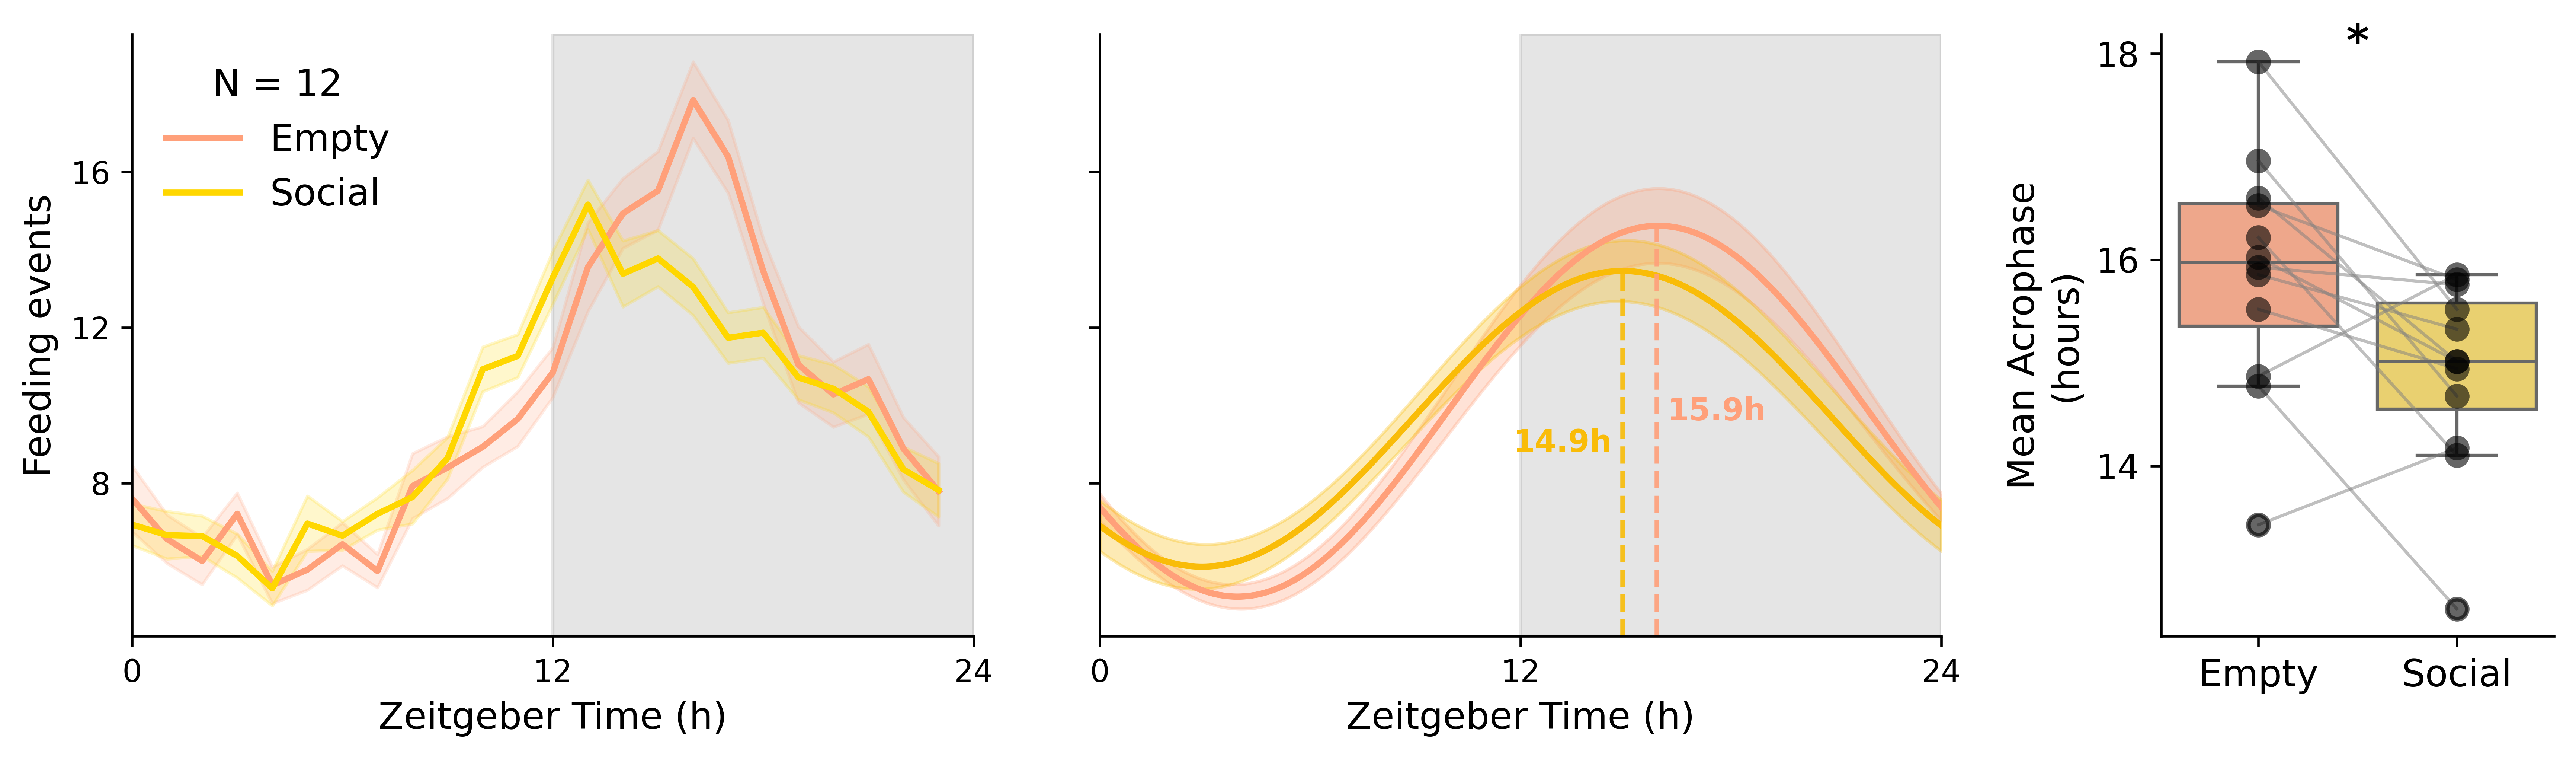

In [3]:
# @title Figure 4C-D
fed2= pd.read_csv(r'https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_Figure4_cd.csv')
emp=fed2.query("Mode == 'empty'")
emp1 = emp.groupby(["FED",'Mode',"zthour"])["Binary_Pellets"].mean().reset_index()
emp1.columns = ['id','mode','zthour','events']
emp1['id'] = emp1['id'].str.replace(r'FED0(\d+)', r'\1_eFeeding', regex=True)
soc=fed2.query("Mode == 'social'")
soc1 = soc.groupby(["FED","Mode","zthour"])["Binary_Pellets"].mean().reset_index()
soc1.columns = ['id','mode','zthour','events']
soc1['id'] = soc1['id'].str.replace(r'FED0(\d+)', r'\1_sFeeding', regex=True)
d = pd.concat([emp1,soc1], ignore_index=True)
# Split the 'id' column into two new columns: 'col1' and 'col2'
d[['col1', 'col2']] = d['id'].str.split('_', expand=True)

# Pivot the DataFrame to make 'zthour' the columns
melted_df1 = d.pivot_table(index=['col1', 'col2'], columns='zthour', values='events', aggfunc='first').reset_index()

# Rename the columns to make them clear
melted_df1.columns.name = None  # Remove the pivot table column name
melted_df1.rename(columns={'col1': 'Mouse', 'col2': 'Measurement'}, inplace=True)
melted_df1.fillna(0, inplace = True)
# === Convert wide format to long ===
df_long1 = melted_df1.melt(id_vars=['Mouse', 'Measurement'],
                  var_name='Hour', value_name='Value')
df_long1['Hour'] = df_long1['Hour'].astype(int)

# === Pivot so each measurement type becomes a column ===
df_pivot1 = df_long1.pivot_table(index=['Mouse', 'Hour'],
                                columns='Measurement', values='Value').reset_index()

# === Define cosinor model ===
def cosinor(t, mesor, amplitude, acrophase):
    return mesor + amplitude * np.cos(2 * np.pi * (t - acrophase) / 24)

# === Run cosinor analysis per Mouse and Measurement ===
fit_results1 = []

for measurement in ['eFeeding', 'sFeeding']:
    for mouse_id, group in df_pivot1.groupby('Mouse'):
        if measurement not in group.columns:
            continue

        hourly = group.set_index('Hour')[measurement].reindex(range(24), fill_value=np.nan)
        hourly = hourly.interpolate(method='spline', order=2, limit_direction='both')

        t = hourly.index.to_numpy()
        y = hourly.values
        guess = [np.mean(y), (np.max(y) - np.min(y)) / 2, 0]

        try:
            params, _ = curve_fit(cosinor, t, y, p0=guess)
            mesor, amplitude, acrophase = params

            if amplitude < 0:
                amplitude = -amplitude
                acrophase = (acrophase + 12) % 24

            t_fit = np.linspace(0, 24, 1000)
            y_fit = cosinor(t_fit, mesor, amplitude, acrophase)
            fit_peak_hour = t_fit[np.argmax(y_fit)]

            y_pred = cosinor(t, mesor, amplitude, acrophase)
            r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)

        except RuntimeError:
            mesor, amplitude, acrophase, fit_peak_hour, r2 = [np.nan] * 5

        fit_results1.append({
            'Mouse': mouse_id,
            'Measurement': measurement,
            'MESOR': mesor,
            'Amplitude': amplitude,
            'Acrophase_Hour': fit_peak_hour,
            'R_squared': r2
        })

fit_df1 = pd.DataFrame(fit_results1)

# Convert hours to radians
fit_df1['Acrophase_rad'] = 2 * np.pi * fit_df1['Acrophase_Hour'] / 24

# Define circular mean function (safe for radians)
def circ_mean(theta):
    sin_sum = np.sum(np.sin(theta))
    cos_sum = np.sum(np.cos(theta))
    return np.arctan2(sin_sum, cos_sum) % (2 * np.pi)

# Prepare list to collect results
circ_summary1 = []

# Loop through each Mouse × Measurement pair
for (mouse, measurement), sub in fit_df1.groupby(['Mouse', 'Measurement']):
    theta = sub['Acrophase_rad'].dropna().values
    if len(theta) == 0:
        continue

    mu = circ_mean(theta)
    circ_summary1.append({
        'Mouse': mouse,
        'Measurement': measurement,
        'Acrophase_rad_mean': mu,
        'Acrophase_deg_mean': np.degrees(mu) % 360,
        'Acrophase_hour_mean': (24 * mu / (2 * np.pi)) % 24
    })

# Create the summary DataFrame
acrophase_df1 = pd.DataFrame(circ_summary1)

# Ensure correct order
measurements = ['Empty','Social']
acrophase_df1['Measurement'] = acrophase_df1['Measurement'].replace({
    'eFeeding': 'Empty',
    'sFeeding': 'Social',
})

acrophase_df1['Measurement'] = pd.Categorical(
    acrophase_df1['Measurement'],
    categories=['Empty', 'Social'],
    ordered=True
)

# === Compute and print paired summary stats for acrophase and amplitude ===
def paired_stats(df, value_col):
  wide = df.pivot(index='Mouse', columns='Measurement', values=value_col)
  if 'Empty' in wide.columns and 'Social' in wide.columns:
      diff = wide['Empty'] - wide['Social']
      mean_diff = diff.mean()
      sd_diff = diff.std(ddof=1)
      se_diff = sd_diff / np.sqrt(len(diff))
      return mean_diff, sd_diff, se_diff
  else:
      return np.nan, np.nan, np.nan

def p_to_star(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return f"p = {p:.2f}"  # optional: or return an empty string ""

t_fit = np.linspace(0, 24, 1000)
condition_map = {'eFeeding': 'Empty', 'sFeeding': 'Social'}
color_map = {'Empty': 'lightsalmon', 'Social': '#f9bc08'}

# -- Cosinor-fitted values for each mouse
all_fits = []
for measurement, label_cond in condition_map.items():
    for mouse_id in df_pivot1['Mouse'].unique():
        result = fit_df1[(fit_df1['Mouse'] == mouse_id) & (fit_df1['Measurement'] == measurement)]
        if result.empty or result.isna().any().any():
            continue

        mesor = result['MESOR'].values[0]
        amp = result['Amplitude'].values[0]
        acro = result['Acrophase_Hour'].values[0]
        y_fit = cosinor(t_fit, mesor, amp, acro)

        temp_df = pd.DataFrame({
            'Time': t_fit,
            'Fitted': y_fit,
            'Mouse': mouse_id,
            'Condition': label_cond
        })
        all_fits.append(temp_df)

fit_df_all = pd.concat(all_fits, ignore_index=True)

# === Layout setup: 1 row, 3 columns ===
fig = plt.figure(figsize=(14, 3.5), dpi=600)
outer = GridSpec(1, 3, width_ratios=[1.5, 1.5, 0.7], wspace=0.25)

ax1 = fig.add_subplot(outer[0])
ax2 = fig.add_subplot(outer[1], sharey=ax1)  # sharey from ax1
plt.setp(ax2.get_yticklabels(), visible=False)

ax_box1 = fig.add_subplot(outer[2])  # Only Acrophase plot now

# === LEFT: Raw pellet timecourse ===
sns.lineplot(data=emp, x="zthour", y="Binary_Pellets", color="lightsalmon",linewidth=2,
              label="Empty", errorbar="se", ax=ax1)
sns.lineplot(data=soc, x="zthour", y="Binary_Pellets", color="gold",linewidth=2,
              label="Social", errorbar="se", ax=ax1)

ax1.set_xticks([0, 12, 24])
ax1.set_xlim(0, 24)
ax1.set_xlabel('Zeitgeber Time (h)', fontsize=12)
ax1.set_ylabel('Feeding events', fontsize=12)
ax1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=4))
ax1.axvspan(12, 24, color='gray', alpha=0.2, zorder=0)
ax1.legend(title=f"N = {len(df_pivot1['Mouse'].unique())}", title_fontsize=12,
            loc='upper left', frameon=False, fontsize=12)
sns.despine(ax=ax1)

# === CENTER: Cosinor fit ± SEM ===
for condition in ['Empty', 'Social']:
    subset = fit_df_all[fit_df_all['Condition'] == condition]
    grouped = subset.groupby('Time')['Fitted']
    mean_curve = grouped.mean()
    sem_curve = grouped.sem()

    ax2.plot(t_fit, mean_curve, label=condition, color=color_map[condition],linewidth=2,)
    ax2.fill_between(t_fit, mean_curve - sem_curve, mean_curve + sem_curve,
                      color=color_map[condition], alpha=0.3)

ax2.axvspan(12, 24, color='gray', alpha=0.2, zorder=0)
ax2.set_xticks([0, 12, 24])
ax2.set_xlim(0, 24)
ax2.set_xlabel('Zeitgeber Time (h)', fontsize=12)
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=5))
ax2.legend([], [], frameon=False)
sns.despine(ax=ax2)

# --- RIGHT TOP: Acrophase boxplot ---
# Pivot data to wide format for Wilcoxon
acrophase_wide = acrophase_df1.pivot(index='Mouse', columns='Measurement', values='Acrophase_hour_mean')
stat_acro, pval = wilcoxon(acrophase_wide['Empty'], acrophase_wide['Social'])
print(f"Wilcoxon Acrophase p-value: {pval:.3f}")

sns.boxplot(data=acrophase_df1, x='Measurement', y='Acrophase_hour_mean',
            palette=['lightsalmon', '#fddc5c'], ax=ax_box1)
sns.stripplot(data=acrophase_df1, x='Measurement', y='Acrophase_hour_mean',
              color='k', alpha=0.6, jitter=False, size=8, ax=ax_box1)
name_map = {'eFeeding': 'Empty', 'sFeeding': 'Social'}
measure_lookup = [name_map[m] for m in ["eFeeding", "sFeeding"]]

for mouse_id, sub in acrophase_df1.groupby('Mouse'):
    if sub['Measurement'].nunique() >= 2:
        sub_sorted = sub.sort_values('Measurement')
        x_vals = [measure_lookup.index(name_map[m]) if m in name_map else measure_lookup.index(m)
                for m in sub_sorted['Measurement']]
        y_vals = sub_sorted['Acrophase_hour_mean'].values
        ax_box1.plot(x_vals, y_vals, color='gray', alpha=0.5, linewidth=1)

label_star = p_to_star(pval)
ax_box1.text(0.5, 1.02, label_star,
          transform=ax_box1.transAxes, ha='center', va='top',
          fontsize=14, fontweight='bold',)
ax_box1.set_ylabel("Mean Acrophase\n(hours)", fontsize=12)
ax_box1.set_xlabel("")
ax_box1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=5))
ax_box1.tick_params(axis='y', labelsize=11)
ax_box1.tick_params(axis='x', labelsize=12)
sns.despine(ax=ax_box1)

box = ax2.get_position()
ax2.set_position([box.x0 - 0.015, box.y0, box.width, box.height])

# === Add vertical dashed lines at group mean acrophase ===
ymin, ymax = ax2.get_ylim()

# Store acrophase values and heights
acro_labels = []

for measure, condition in condition_map.items():
    acro_mean = fit_df1[fit_df1['Measurement'] == measure]['Acrophase_Hour'].mean()
    subset = fit_df_all[fit_df_all['Condition'] == condition]
    grouped = subset.groupby('Time')['Fitted'].mean()
    y_mean_at_acro = np.interp(acro_mean, grouped.index.values, grouped.values)

    acro_labels.append({
        "condition": condition,
        "x": acro_mean,
        "y": y_mean_at_acro,
        "color": color_map[condition]
    })

    # Draw vertical line
    ax2.vlines(acro_mean, ymin=0, ymax=y_mean_at_acro,
            linestyle='--', color=color_map[condition], linewidth=1.5, alpha=0.9)

# === Place acrophase labels halfway up, outside the vertical lines ===
x_offset = 0.3  # horizontal shift outside the vertical lines

# Sort by x so we know which is left and right
sorted_labels = sorted(acro_labels, key=lambda x: x['x'])
left, right = sorted_labels[0], sorted_labels[1]

# LEFT label: left of left line, halfway up its acrophase peak
ax2.text(left['x'] - x_offset, left['y'] * 0.7,
        f"{left['x']:.1f}h",
        color=left['color'],
        ha='right', va='top', fontweight='bold')

# RIGHT label: right of right line, halfway up its acrophase peak
ax2.text(right['x'] + x_offset, right['y'] * 0.7,
        f"{right['x']:.1f}h",
        color=right['color'],
        ha='left', va='top', fontweight='bold')

# 7. Restore original limits to avoid stretching
ax2.set_ylim(ymin, ymax)

# Acrophase
m_diff_acro, sd_acro, se_acro = paired_stats(acrophase_df1, 'Acrophase_hour_mean')
print(f"\n🕒 Acrophase difference (Empty - Social):")
print(f"Mean = {m_diff_acro:.3f} h | SD = {sd_acro:.3f} | SE = {se_acro:.3f}")

plt.tight_layout()
plt.show()